In [1]:
import torch
import torchphysics as tp
import math
import pytorch_lightning as pl

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [9]:
S = tp.spaces.R2('s')
U = tp.spaces.R1('u')

In [10]:
omega = tp.domains.Parallelogram(S, [0, 0], [0, 1], [1, 0])

In [13]:
inner_sampler = tp.samplers.RandomUniformSampler(omega, n_points=500)
boundary_sampler = tp.samplers.RandomUniformSampler(omega.boundary, n_points=200)

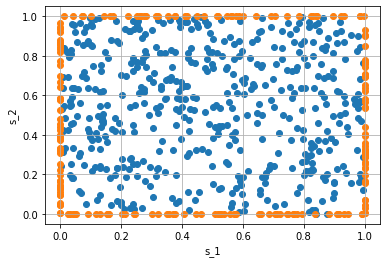

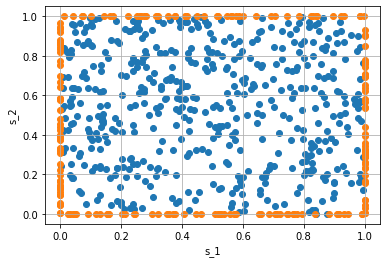

In [14]:
tp.utils.scatter(S, inner_sampler, boundary_sampler)

In [7]:
model = tp.models.Sequential(
    tp.models.NormalizationLayer(omega),
    tp.models.FCN(input_space=S, output_space=U, hidden=(16,16,16))
)

In [15]:
f = lambda s: 2*math.pi**2*torch.sin(math.pi*s[:, 0])*torch.sin(math.pi*s[:, 1])

def poisson_residual(u, s):
    return tp.utils.laplacian(u, s) + f(s)

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=poisson_residual,
                                            name='poisson_condition')

In [16]:
def boundary_residual(u):
    return u

boundary_condition = tp.conditions.PINNCondition(module=model,
                                                 sampler=boundary_sampler,
                                                 residual_fn=boundary_residual,
                                                 name='boundary_condition')

In [ ]:
solver = tp.solver.Solver([pde_condition,
                           boundary_condition])

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

trainer = pl.Trainer(gpus=0, # or None for CPU
                     max_steps=1000,
                     #logger=False,
                     benchmark=True,
                     log_every_n_steps=1,
                     #val_check_interval=1000,
                     checkpoint_callback=False)
trainer.fit(solver)